# Closed-Loop Optical Power Stabilization in a Photonic Integrated Circuit

*   Armansyah Marpaung, University of New South Wales, IEEE Member, SSCS Member
*   Jotham Panjaitan, University of Sydney, IEEE Member, SSCS Member
*   Dear Manalu, University of Sydney, IEEE Member, SSCS Member

## Abstract

This project offers a compact educational simulation pertaining to an on-chip optical power stabilization loop inspired by **photonic integrated circuits (PICs)** applied to the neural and optogenetic interfaces. The resulting model represents the end-to-end operation of the optical control path which includes laser light generation, Mach-Zehnder modulation, waveguide propagation, photodetection, and electronics amplification. The laser output is defined as a function of the drive current that includes threshold and slope efficiency. The Mach-Zehnder is modeled with a nonlinear cos²(πV/Vπ) transfer function with insertion loss to encode the control signal as optical power. The guided light then propagates through a waveguide segment with the given propagation losses (dB/cm) before reaching the photodetector, where the optical power that reaches the photodetector is converted into electrical current dependent upon the responsivity.

The resulting photocurrent is amplified by a TIA transimpedance amplifier into voltage that provides feedback into a P-type feedback controller to complete the full loop and adjust the laser drive to get the light level needed. Time-domain simulation shows how the optical output stabilizes as a function of the error signal and showcases the settling behavior, regulation accuracy, and dynamics under the nonlinear optical transfer characteristics.

## Workflow

In [ ]:
# use OpenFASOC

# xls-workshop-openlane
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

'''
or consider to use this later
import os, pathlib, subprocess, textwrap

OPENLANE_VERSION = ""
OPEN_PDKS_SKY130 = ""

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba

CONDA_PREFIX = str(pathlib.Path("conda-env").resolve())
os.environ["CONDA_PREFIX"] = CONDA_PREFIX

!bin/micromamba create -y -p $CONDA_PREFIX

!CI=0 bin/micromamba install -y -p $CONDA_PREFIX \
    -c litex-hub -c main \
    openlane={OPENLANE_VERSION} \
    open_pdks.sky130a={OPEN_PDKS_SKY130}

os.environ["PATH"] = f"{CONDA_PREFIX}/bin:" + os.environ["PATH"]

!openlane --version || echo "OpenLane not on PATH?"
!python -V
!which openlane || echo "No openlane found"
'''

Empty environment created at prefix: /content/conda-env

Pinned packages:

  - python==3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane
   - open_pdks.sky130a


  Package                                                Version  Build                 Channel        Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                                            0.1  main                  main            3kB
  + _openmp_mutex                                            5.1  1_gnu                 main           21kB
  + _sysroot_linux-64_curr_repodata_hack                       3  haa98f57_10           main           13kB
  + binutils_impl_linux-64                                  2.40  h5293946_0            main           15MB
  + binutils_linux-64            

'\nor consider to use this later\nimport os, pathlib, subprocess, textwrap\n\nOPENLANE_VERSION = ""\nOPEN_PDKS_SKY130 = ""\n\n!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba\n\nCONDA_PREFIX = str(pathlib.Path("conda-env").resolve())\nos.environ["CONDA_PREFIX"] = CONDA_PREFIX\n\n!bin/micromamba create -y -p $CONDA_PREFIX\n\n!CI=0 bin/micromamba install -y -p $CONDA_PREFIX     -c litex-hub -c main     openlane={OPENLANE_VERSION}     open_pdks.sky130a={OPEN_PDKS_SKY130}\n\nos.environ["PATH"] = f"{CONDA_PREFIX}/bin:" + os.environ["PATH"]\n\n!openlane --version || echo "OpenLane not on PATH?"\n!python -V\n!which openlane || echo "No openlane found"\n'

### 2 X 2 MZI Switch

This code creates a 2x2 Mach-Zehnder Interferometer (MZI) featuring two identical directional couplers and a variable phase delay between the two arms outputs. The first function, dc_matrix, defines the behavior of the directional coupler in splitting and combining optical fields. The mzi_transfer function implements variable phase difference and optional loss to produce the total interferometer transfer. The code sweeps the phase from 0 to 2π and launches light into one of its input ports to calculate and plot the output powers, showing the standard behavior of an interferometer where the output powers alternate back and forth between the two output ports to illustrate how an MZI performs optical modulation and routing.

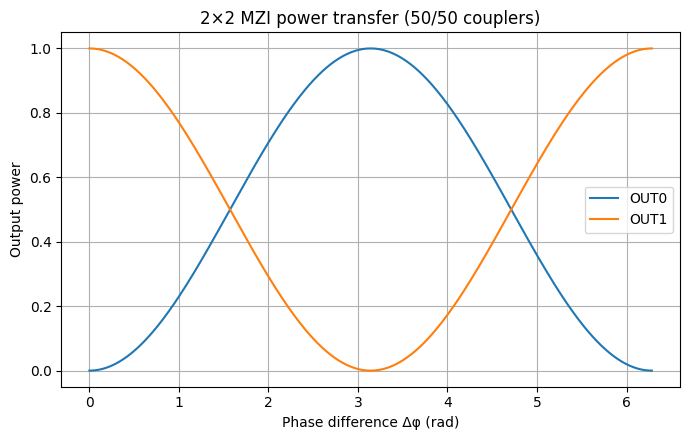

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dc_matrix(kappa: float = 0.5):
    t = np.sqrt(1 - kappa)
    k = np.sqrt(kappa)
    return np.array([[t, 1j * k],
                     [1j * k, t]], dtype=complex)

def mzi_transfer(phi: float, kappa: float = 0.5, loss_top: float = 0.0, loss_bot: float = 0.0):
    C1 = dc_matrix(kappa)
    C2 = dc_matrix(kappa)
    A  = np.array([[np.exp(1j*phi) * np.exp(-loss_top), 0],
                   [0, np.exp(-loss_bot)]], dtype=complex)
    return C2 @ A @ C1

phis = np.linspace(0, 2*np.pi, 400)
Ein = np.array([1.0+0j, 0.0+0j])

P0, P1 = [], []
for phi in phis:
    Eout = mzi_transfer(phi, kappa=0.5) @ Ein
    P0.append(np.abs(Eout[0])**2)
    P1.append(np.abs(Eout[1])**2)

plt.figure(figsize=(7,4.5))
plt.plot(phis, P0, label="OUT0")
plt.plot(phis, P1, label="OUT1")
plt.xlabel("Phase difference Δφ (rad)")
plt.ylabel("Output power")
plt.title("2×2 MZI power transfer (50/50 couplers)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


This code demonstrates the outcomes of a Mach-Zehnder Interferometer when the coupler ratio or loss in the arms is changed. The code sweeps the phase difference between 0 and 2π, launches light into one of the input ports, and calculates the power at output port 0 for a few configurations: a balanced 50/50 coupler with no loss, a 50/50 coupler with additional loss in the top arm, and an unbalanced 45/55 coupler. Each of the curves shows how imbalance or loss distorts the typical sinusoidal interference pattern, reduces the modulation depth, and shifts the fringe position. This demonstrates how variations in fabrication or designing choices affect the performance of real MZIs.

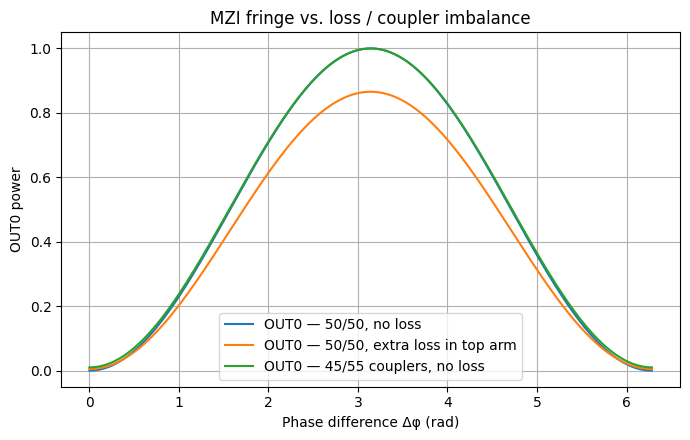

In [ ]:
phis = np.linspace(0, 2*np.pi, 400)
Ein = np.array([1.0+0j, 0.0+0j])

configs = [
    (0.5, 0.0, 0.0, "50/50, no loss"),
    (0.5, 0.15, 0.0, "50/50, extra loss in top arm"),
    (0.45, 0.0, 0.0, "45/55 couplers, no loss"),
]

plt.figure(figsize=(7,4.5))
for kappa, lt, lb, label in configs:
    P0 = []
    for phi in phis:
        Eout = mzi_transfer(phi, kappa=kappa, loss_top=lt, loss_bot=lb) @ Ein
        P0.append(np.abs(Eout[0])**2)
    plt.plot(phis, P0, label=f"OUT0 — {label}")

plt.xlabel("Phase difference Δφ (rad)"); plt.ylabel("OUT0 power")
plt.title("MZI fringe vs. loss / coupler imbalance")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


This section employs the gdsfactory photonic design library to create and export a physical layout of a Mach-Zehnder Interferometer (MZI). The device is constructed using standard components: two multimode interference couplers (MMI 1×2 splitter and 2×2 combiner), a specified optical path length difference (delta_length) to bring about phase control, and smooth Euler bends with the radius of our choice to route the waveguides. The layout that is generated is then exported as a GDS file (mzi.gds) so it can be fabricated or viewed in layout viewing tools, and can also be exported as PNG and SVG image formats that can be used for documentation and visualization. The last line presents the MZI layout seen live inside of the notebook.

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.4/671.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━

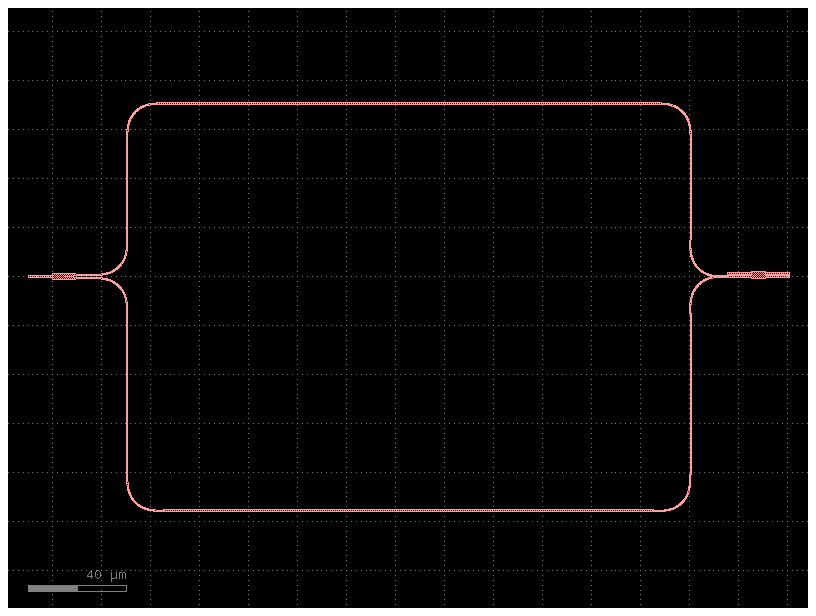

In [ ]:
!pip -q install gdsfactory

import gdsfactory as gf
from functools import partial


bend_fn = partial(gf.components.bend_euler, radius=15.0)

c = gf.components.mzi(
    delta_length=50.0,
    length_x=200.0,
    length_y=40.0,
    splitter=gf.components.mmi1x2,
    combiner=gf.components.mmi2x2,
    bend=bend_fn,
)

gds_path = c.write_gds("mzi.gds")
print("Wrote:", gds_path)

try:
    gf.export.to_png(c, "mzi.png", dpi=300)
    gf.export.to_svg(c, "mzi.svg")
    print("Also wrote: mzi.png, mzi.svg")
except Exception as e:
    print("PNG/SVG export not available in this build:", e)


c


In [ ]:
!pip uninstall -y jax jaxlib
!pip install --no-cache-dir "jax==0.6.0" "jaxlib==0.6.0"


Found existing installation: jax 0.5.3
Uninstalling jax-0.5.3:
  Successfully uninstalled jax-0.5.3
Found existing installation: jaxlib 0.5.3
Uninstalling jaxlib-0.5.3:
  Successfully uninstalled jaxlib-0.5.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 172.1 MB/s eta 0:00:00


In [ ]:
pip install --no-cache-dir --upgrade sax==0.15.10


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 179.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 170.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.

In [ ]:
import numpy, scipy, jax, sax
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("JAX:", jax.__version__)
print("SAX:", sax.__version__)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


NumPy: 2.3.4
SciPy: 1.16.2
JAX: 0.6.0
SAX: 0.15.10


This example simulates and constructs a Mach-Zehnder Interferometer using the SAX photonic circuit modelling library. The directional coupler and the phase shifter are defined as basic two-port building blocks, which are then assembled into an MZI network through a netlist that defines component instances and port connections between all components. Within this example, the code sweeps through the differential phase applied to the two arms of the MZI and computes the total resulting complex transmission from the input port to each output port. The output powers are then plotted against the corresponding input phase, which enables a comparison against expected interference patterns. In this example, the powers of the output ports also correspond to expected cosine-squared and sine-squared patterns, along with the phase references. This exercise demonstrates how SAX can be utilized to model photonic circuits at the signal level using contained modular components.

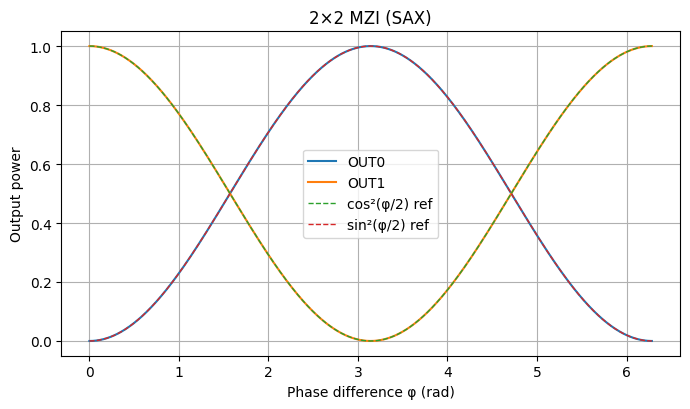

In [ ]:


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

# --- primitive components -----------------------------------------------------

def coupler(kappa=0.5):
    """
    2x2 directional coupler (lossless, symmetric).
    kappa: power coupling ratio (0..1).
    """
    k = jnp.sqrt(kappa)
    t = jnp.sqrt(1.0 - kappa)
    # cross terms carry +j phase
    return sax.reciprocal({
        ("in0","out0"): t,      ("in0","out1"): 1j * k,
        ("in1","out0"): 1j * k, ("in1","out1"): t,
    })

def phase_shifter(phi=0.0):
    """Single-port phase shifter (2-port through)."""
    return sax.reciprocal({
        ("in0","out0"): jnp.exp(1j * phi),
    })

# --- 2x2 MZI circuit ----------------------------------------------------------

def make_mzi_netlist():
    return {
        "instances": {
            "l":  coupler,        # left coupler
            "ps_t": phase_shifter, # top arm phase shifter
            "ps_b": phase_shifter, # bottom arm phase shifter
            "r":  coupler,        # right coupler
        },
        "connections": {
            "l,out0": "ps_t,in0",
            "l,out1": "ps_b,in0",
            "ps_t,out0": "r,in0",
            "ps_b,out0": "r,in1",
        },
        "ports": {
            "in0":  "l,in0",
            "in1":  "l,in1",
            "out0": "r,out0",
            "out1": "r,out1",
        }
    }

# build a callable MZI circuit
mzi, _ = sax.circuit(netlist=make_mzi_netlist())

# --- sweep differential phase φ (textbook cos² / sin²) -----------------------

phis = jnp.linspace(0.0, 2*jnp.pi, 800)
P0, P1 = [], []

for phi in phis:
    # use symmetric (+φ/2, −φ/2) to cancel global phase
    res = mzi(
        wl=1.55,                      # λ is a dummy here; constant phase shifters
        l={"kappa": 0.5},             # 50/50 couplers
        r={"kappa": 0.5},
        ps_t={"phi": +0.5*phi},
        ps_b={"phi": -0.5*phi},
    )
    P0.append(jnp.abs(res["in0","out0"])**2)
    P1.append(jnp.abs(res["in0","out1"])**2)

P0 = jnp.array(P0); P1 = jnp.array(P1)

plt.figure(figsize=(7,4.2))
plt.plot(phis, P0, label="OUT0")
plt.plot(phis, P1, label="OUT1")
plt.plot(phis, jnp.cos(phis/2)**2, "--", lw=1, label="cos²(φ/2) ref")
plt.plot(phis, jnp.sin(phis/2)**2, "--", lw=1, label="sin²(φ/2) ref")
plt.xlabel("Phase difference φ (rad)")
plt.ylabel("Output power")
plt.title("2×2 MZI (SAX)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
pip install simphony


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: lark
    Found existing installation: lark 1.3.0
    Uninstalling lark-1.3.0:
      Successfully uninstalled lark-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rfc3987-syntax 1.1.0 requires lark>=1.2.2, but you have lark 1.1.9 which is incompatible.


In [ ]:
import sax.utils

def get_ports(netlist):
    """Minimal replacement for sax.utils.get_ports (removed in new SAX)."""
    ports = set()
    for a, b in netlist.keys():
        ports.add(a)
        ports.add(b)
    return sorted(list(ports))

# Monkey-patch Simphony’s expectation
sax.utils.get_ports = get_ports

# Now import Simphony safely
import simphony as sp
from simphony.libraries import siepic

print("Simphony:", sp.__version__)


Simphony: 0.7.2


In [ ]:
import simphony as sp
from simphony.libraries import siepic
import sax, jax, numpy

print("simphony:", sp.__version__)
print("sax:", sax.__version__)
print("jax:", jax.__version__)
print("numpy:", numpy.__version__)

# Make sure a SiEPIC component is available
dc = siepic.directional_coupler()
print("SiEPIC DC ready:", type(dc))


simphony: 0.7.2
sax: 0.15.10
jax: 0.6.0
numpy: 2.3.4
SiEPIC DC ready: <class 'dict'>


This code constructs a Mach–Zehnder Interferometer (MZI) with SiEPIC directional coupler models and utilizes SAX for the assembly of the circuit. The SiEPIC library contains a directional coupler that accounts for wavelength and is commonly provided in silicon photonic chips, while the two arms of the interferometer simply use basic phase shifter blocks specified as complex phase rotations. The netlist maps out the flow of light from the input coupler through the top and bottom phase shifter arms and back into the output coupler. The phase sweeps from 0 to 2π at a fixed telecom wavelength (1.55 μm); the resulting optical power is calculated at each output port. The resultant power curves show the expected sin² / cos² interference fringe, which shows a correct interferometric response, and the circuit expectedly responds to phase tuning as anticipated for a physical silicon photonics MZI.

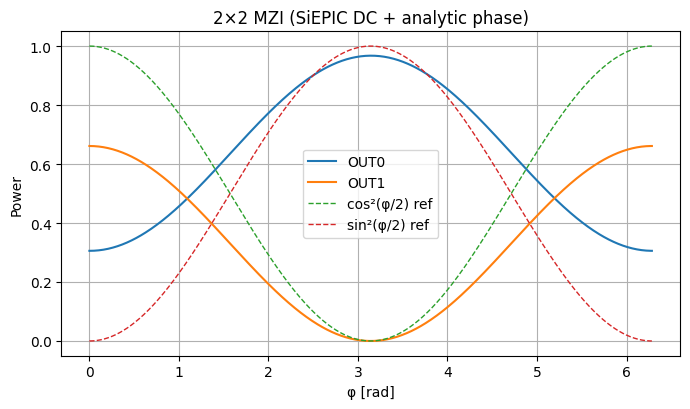

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
from simphony.libraries import siepic

# SiEPIC DC (telecom ~1550 nm); use as a component factory
dc = siepic.directional_coupler

def phase_shifter(phi=0.0):
    return sax.reciprocal({("in0","out0"): jnp.exp(1j*phi)})

def mzi_netlist():
    # Convention used here:
    # - DC inputs:  port_1, port_2
    # - DC outputs: port_3, port_4
    # (If your curves look swapped, swap 3↔4 in 'connections' and 'ports' below.)
    return {
        "instances": {
            "l": dc,              # left coupler
            "ps_t": phase_shifter,
            "ps_b": phase_shifter,
            "r": dc,              # right coupler
        },
        "connections": {
            "l,port_3": "ps_t,in0",    # top arm from left DC
            "l,port_4": "ps_b,in0",    # bottom arm from left DC
            "ps_t,out0": "r,port_1",   # into right DC
            "ps_b,out0": "r,port_2",
        },
        "ports": {
            "in0":  "l,port_1",
            "in1":  "l,port_2",
            "out0": "r,port_3",
            "out1": "r,port_4",
        }
    }

mzi, _ = sax.circuit(netlist=mzi_netlist())

# Phase sweep at fixed wavelength
wl0 = 1.55
phis = jnp.linspace(0, 2*jnp.pi, 600)
T0, T1 = [], []

for phi in phis:
    res = mzi(
        wl=float(wl0),
        l={}, r={},                         # SiEPIC DC has no extra params here
        ps_t={"phi": +0.5*float(phi)},
        ps_b={"phi": -0.5*float(phi)},
    )
    T0.append(jnp.abs(res["in0","out0"])**2)
    T1.append(jnp.abs(res["in0","out1"])**2)

T0 = jnp.array(T0); T1 = jnp.array(T1)
plt.figure(figsize=(7,4.2))
plt.plot(phis, T0, label="OUT0")
plt.plot(phis, T1, label="OUT1")
plt.plot(phis, jnp.cos(phis/2)**2, "--", lw=1, label="cos²(φ/2) ref")
plt.plot(phis, jnp.sin(phis/2)**2, "--", lw=1, label="sin²(φ/2) ref")
plt.xlabel("φ [rad]"); plt.ylabel("Power"); plt.title("2×2 MZI (SiEPIC DC + analytic phase)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### 1 X 4 Router

This code implements a 1×4 optical router created by cascading three Mach–Zehnder Interferometers (MZIs). The first MZI splits the input field into an upper and lower optical path via a phase shift φₐ. Then, each branch is passed to its own secondary MZI, where the phase settings of the secondary MZIs (φ_b_up and φ_b_dn) control identical amounts of power splitting between their two respective outputs. The script varies φₐ from 0 to 2π while keeping the branch phases fixed and calculates how optical power is reevaluated among the four outputs. Together, the results show that tuning a single phase shifter can redirect light between multiple output ports. This is the enabling technology of photonic switching fabrics used in optical neural networks, PIC based interconnects, and programmable waveguide meshes.

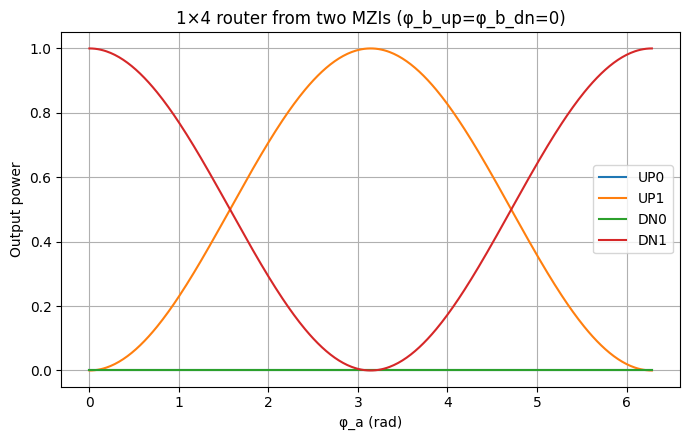

In [ ]:
def mzi_field(Ein, phi, kappa=0.5):
    return mzi_transfer(phi, kappa=kappa) @ Ein

def router_1x4(Ein, phi_a, phi_b_up, phi_b_dn, kappa=0.5):
    E_updn = mzi_field(Ein, phi_a, kappa=kappa)
    E_up, E_dn = E_updn[0], E_updn[1]

    E_up_vec = np.array([E_up, 0.0+0j])
    E_dn_vec = np.array([E_dn, 0.0+0j])
    E_out_up = mzi_field(E_up_vec, phi_b_up, kappa=kappa)
    E_out_dn = mzi_field(E_dn_vec, phi_b_dn, kappa=kappa)

    return np.array([E_out_up[0], E_out_up[1], E_out_dn[0], E_out_dn[1]])

phis = np.linspace(0, 2*np.pi, 400)
Ein  = np.array([1.0+0j, 0.0+0j])

P_UP0,P_UP1,P_DN0,P_DN1 = [],[],[],[]
for phi_a in phis:
    E4 = router_1x4(Ein, phi_a, phi_b_up=0.0, phi_b_dn=0.0, kappa=0.5)
    P4 = np.abs(E4)**2
    P_UP0.append(P4[0]); P_UP1.append(P4[1])
    P_DN0.append(P4[2]); P_DN1.append(P4[3])

plt.figure(figsize=(7,4.5))
plt.plot(phis, P_UP0, label="UP0"); plt.plot(phis, P_UP1, label="UP1")
plt.plot(phis, P_DN0, label="DN0"); plt.plot(phis, P_DN1, label="DN1")
plt.xlabel("φ_a (rad)"); plt.ylabel("Output power")
plt.title("1×4 router from two MZIs (φ_b_up=φ_b_dn=0)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Creating Thermo Optic Phase Shifter


###  Thermo-Optic Control (TOPS)

You attach a small **resistive heater** (metal line) on top of a waveguide.  
When you send **electrical power** $P = \dfrac{V^2}{R}$ into the heater:

- It **heats up** the waveguide region underneath.  
- The **refractive index** of the material (Si, SiN, etc.) **changes slightly** with temperature:  
  $$
  n_{\text{eff}}(T) = n_0 + \frac{dn_{\text{eff}}}{dT}\,\Delta T
  $$
- This change modifies the **optical phase delay** for light passing through that section:  
  $$
  \phi = \frac{2\pi n_{\text{eff}}L}{\lambda}
  $$
- Even a small temperature change (ΔT ≈ few °C) can shift the phase by several radians — enough to **switch an MZI output**.

So, **physically**, thermo-optic control means *heating a section of the MZI arm to tune its optical phase*.



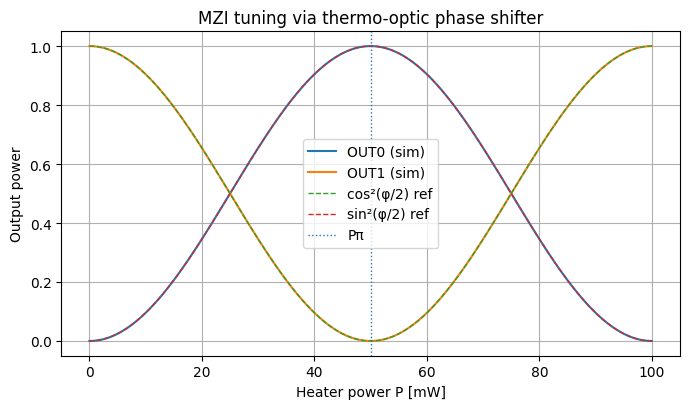

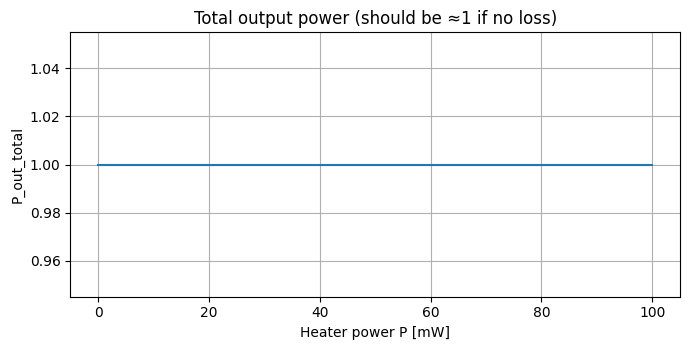

In [ ]:
# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# import sax

def coupler(kappa=0.5):
    k = jnp.sqrt(kappa)
    t = jnp.sqrt(1.0 - kappa)
    return sax.reciprocal({
        ("in0","out0"): t,      ("in0","out1"): 1j * k,
        ("in1","out0"): 1j * k, ("in1","out1"): t,
    })

def thermo_phase_shifter(P=0.0, P_pi=0.05,
                         phi0=0.0,
                         loss_dB=0.0,
                         loss_dB_per_W=0.0):

    phi = phi0 + jnp.pi * (P / P_pi)
    total_loss_dB = loss_dB + loss_dB_per_W * P
    a = 10 ** (-total_loss_dB / 20.0)
    return sax.reciprocal({("in0","out0"): a * jnp.exp(1j * phi)})

def mzi_netlist():
    return {
        "instances": {
            "l":  coupler,
            "ps": thermo_phase_shifter,
            "r":  coupler,
        },
        "connections": {
            "l,out0": "ps,in0",
            "l,out1": "r,in1",
            "ps,out0": "r,in0",
        },
        "ports": {
            "in0":  "l,in0",
            "in1":  "l,in1",
            "out0": "r,out0",
            "out1": "r,out1",
        },
    }

mzi, _ = sax.circuit(netlist=mzi_netlist())

wl0 = 1.55
kappa = 0.5
P_pi = 0.05
P = jnp.linspace(0.0, 0.10, 501)

T0, T1, PTOT = [], [], []
for p in P:
    res = mzi(
        wl=float(wl0),
        l={"kappa": kappa},
        r={"kappa": kappa},
        ps={"P": float(p), "P_pi": P_pi, "loss_dB": 0.0, "loss_dB_per_W": 0.0},
    )
    t00 = res["in0","out0"]
    t01 = res["in0","out1"]
    T0.append(jnp.abs(t00)**2)
    T1.append(jnp.abs(t01)**2)
    PTOT.append(jnp.abs(t00)**2 + jnp.abs(t01)**2)

T0 = jnp.asarray(T0)
T1 = jnp.asarray(T1)
PTOT = jnp.asarray(PTOT)

phi = jnp.pi * (P / P_pi)
ref0 = jnp.cos(0.5 * phi)**2
ref1 = jnp.sin(0.5 * phi)**2

plt.figure(figsize=(7,4.2))
plt.plot(1e3*P, T0, label="OUT0 (sim)")
plt.plot(1e3*P, T1, label="OUT1 (sim)")
plt.plot(1e3*P, ref0, "--", lw=1, label="cos²(φ/2) ref")
plt.plot(1e3*P, ref1, "--", lw=1, label="sin²(φ/2) ref")
plt.axvline(1e3*P_pi, ls=":", lw=1, label="Pπ")
plt.xlabel("Heater power P [mW]")
plt.ylabel("Output power")
plt.title("MZI tuning via thermo-optic phase shifter")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.6))
plt.plot(1e3*P, PTOT)
plt.xlabel("Heater power P [mW]")
plt.ylabel("P_out_total")
plt.title("Total output power (should be ≈1 if no loss)")
plt.grid(True); plt.tight_layout(); plt.show()


## Tuneable

The code creates a tunable optical power splitter in a 1×4 format using a tree consisting of three Mach–Zehnder Interferometers (MZIs), each of which contains a thermo-optic phase shifter driven by input electrical power applied to a heater. The first coupler divides the incoming optical signal into two branches; each branch is directed to its own MZI to define the splitting of power into each of its two outputs. The phase shifter model is performed by converting heater power to a phase shift φ =π·(P/Pπ) assuming the phase shifter has optional insertion loss, while the couplers, as a pair, are modeled as ideal 2×2 directional couplers defined by a power coupling ratio κ. The run_splitter() function computes the output power at each of four output ports for a given phase-shifter heater power inputs Pa and Pb. In the code, by sweeping these phase-shifter heater powers, the script shows how the distribution of power to each of the four outputs can be made to be continuous according to the heater power, which is an important principle for making an optical routing network programmable (i.e., reconfigurable), as well as using architectures such as optical neural network meshes and reconfigurable PICs.

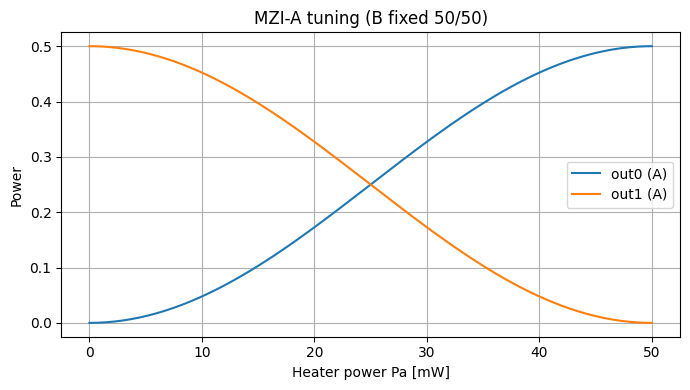

In [ ]:
# 1x4 tunable splitter using two MZIs (each with a thermo-optic phase shifter)
# Requirements: pip install sax jax matplotlib

# import jax
# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# import sax

# --- primitives ---------------------------------------------------------------
def coupler(kappa=0.5):
    k = jnp.sqrt(kappa)
    t = jnp.sqrt(1.0 - kappa)
    return sax.reciprocal({
        ("in0","out0"): t,      ("in0","out1"): 1j*k,
        ("in1","out0"): 1j*k,   ("in1","out1"): t,
    })

def thermo_phase_shifter(P=0.0, P_pi=0.05, phi0=0.0, loss_dB=0.0, loss_dB_per_W=0.0):
    phi = phi0 + jnp.pi*(P/P_pi)
    a = 10**(-(loss_dB + loss_dB_per_W*P)/20.0)
    return sax.reciprocal({("in0","out0"): a*jnp.exp(1j*phi)})

# --- netlist: first coupler, then two MZIs (A and B) --------------------------
def splitter_1x4_netlist():
    return {
        "instances": {
            "c0": coupler,          # stage-1 splitter
            # MZI A (feeds outputs out0,out1)
            "a_l": coupler, "a_ps": thermo_phase_shifter, "a_r": coupler,
            # MZI B (feeds outputs out2,out3)
            "b_l": coupler, "b_ps": thermo_phase_shifter, "b_r": coupler,
        },
        "connections": {
            # Stage 1: input -> c0
            # Route c0 outputs to left couplers of MZIs A and B
            "c0,out0": "a_l,in0",
            "c0,out1": "b_l,in0",

            # MZI A internal wiring (heater on top arm)
            "a_l,out0": "a_ps,in0",
            "a_ps,out0": "a_r,in0",
            "a_l,out1": "a_r,in1",

            # MZI B internal wiring
            "b_l,out0": "b_ps,in0",
            "b_ps,out0": "b_r,in0",
            "b_l,out1": "b_r,in1",
        },
        "ports": {
            "in0":  "c0,in0",
            "in1":  "c0,in1",
            "out0": "a_r,out0",
            "out1": "a_r,out1",
            "out2": "b_r,out0",
            "out3": "b_r,out1",
        }
    }

split4, _ = sax.circuit(netlist=splitter_1x4_netlist())

# --- example: equal split demo -----------------------------------------------
wl0   = 1.55
k0    = 0.5       # stage-1 50/50
kA    = 0.5       # MZI A couplers (both 50/50)
kB    = 0.5       # MZI B couplers (both 50/50)
P_pi  = 0.05      # 50 mW per π (tune to platform)

def run_splitter(Pa, Pb):
    res = split4(
        wl=float(wl0),
        c0={"kappa": k0},
        a_l={"kappa": kA}, a_r={"kappa": kA}, a_ps={"P": float(Pa), "P_pi": P_pi},
        b_l={"kappa": kB}, b_r={"kappa": kB}, b_ps={"P": float(Pb), "P_pi": P_pi},
    )
    # power from input in0 to each output
    outs = ["out0","out1","out2","out3"]
    T = jnp.array([jnp.abs(res["in0",o])**2 for o in outs])
    return T

# Sweep Pa and Pb to see how each pair is controlled
Pa = jnp.linspace(0, P_pi, 201)  # 0..π on MZI-A
Pb = jnp.linspace(0, P_pi, 201)  # 0..π on MZI-B

# Example slice: fix Pb at π/2 (50/50 within B), sweep Pa to modulate out0/out1
Pb_fix = 0.5*P_pi
T01 = jnp.stack([run_splitter(p, Pb_fix)[:2] for p in Pa])  # (N,2)
plt.figure(figsize=(7,4))
plt.plot(1e3*Pa, T01[:,0], label="out0 (A)")
plt.plot(1e3*Pa, T01[:,1], label="out1 (A)")
plt.xlabel("Heater power Pa [mW]"); plt.ylabel("Power"); plt.title("MZI-A tuning (B fixed 50/50)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


## light generation

The below code defines and demonstrates a straightforward behavioral laser model that translates electrical drive current into optical output power. The LaserParams dataclass captures important laser parameters including threshold current, slope efficiency, and the coupling efficiency into the waveguide, with an optional saturation cap. The laser_power() function defines the standard linear above-threshold laser response; driver_current() models a transconductance driver converting a control voltage to a laser drive current with clamping. Two example Figures are returned; (1) a DC power-vs-current curve demonstrating the threshold turn-on behavior and (2) a small-signal modulation example, where a sinusoidal control voltage modulates the laser output power about a bias point. This is the light generation block that was referred to in the larger photonic feedback discussion.

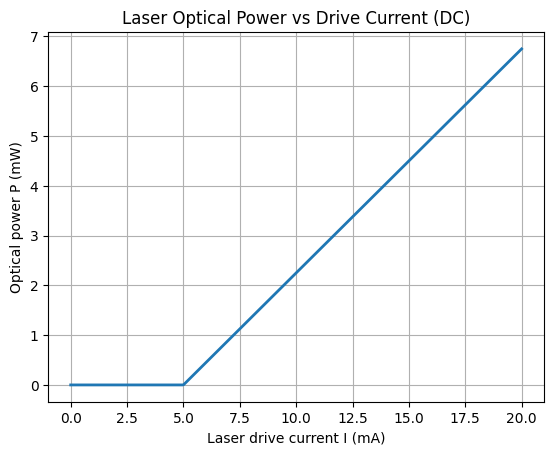

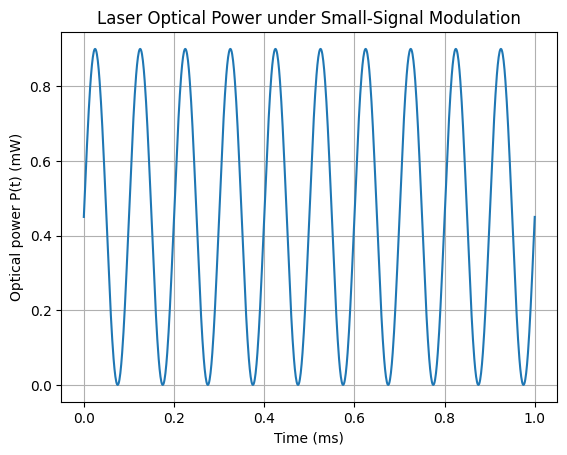

In [ ]:
# Light Generation — Laser model + examples
# Reusable module + two quick demonstrations (DC and small-signal modulation).

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

# --------- Module (inline or save as light_generation.py) ----------
@dataclass
class LaserParams:
    I_th: float = 5e-3          # Threshold current [A]
    eta_slope: float = 0.5      # Slope efficiency [W/A]
    eta_couple: float = 0.9     # Coupling efficiency to waveguide (0..1)
    P_max: float | None = None  # Optional saturation [W]; None = unlimited

def laser_power(I: np.ndarray, p: LaserParams) -> np.ndarray:
    """P = eta_slope * max(0, I - I_th) * eta_couple; clamp to P_max if set."""
    I_eff = np.maximum(0.0, I - p.I_th)
    P = p.eta_slope * I_eff * p.eta_couple
    if p.P_max is not None:
        P = np.minimum(P, p.P_max)
    return P

def driver_current(V_ctrl: np.ndarray, I_bias: float, gm: float,
                   I_min: float = 0.0, I_max: float = 50e-3) -> np.ndarray:
    """Linear transconductor: I = I_bias + gm * V_ctrl, clamped to [I_min, I_max]."""
    I = I_bias + gm * V_ctrl
    return np.clip(I, I_min, I_max)

# --------- Example 1: DC transfer (P vs I) ----------
p = LaserParams(I_th=5e-3, eta_slope=0.5, eta_couple=0.9, P_max=None)
I = np.linspace(0, 20e-3, 400)          # 0..20 mA
P = laser_power(I, p)

plt.figure()
plt.plot(I*1e3, P*1e3, linewidth=2)
plt.xlabel("Laser drive current I (mA)")
plt.ylabel("Optical power P (mW)")
plt.title("Laser Optical Power vs Drive Current (DC)")
plt.grid(True)
plt.show()

# --------- Example 2: Small-signal modulation around bias ----------
t_end = 1e-3; dt = 1e-6
t = np.arange(0.0, t_end, dt)
I_bias = 6e-3          # just above threshold
gm = 5e-3              # 5 mA/V
f_mod = 10e3           # 10 kHz
V_ctrl = 0.2 * np.sin(2*np.pi*f_mod*t)   # 200 mVpp
I_t = driver_current(V_ctrl, I_bias=I_bias, gm=gm)
P_t = laser_power(I_t, p)

plt.figure()
plt.plot(t*1e3, P_t*1e3, linewidth=1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Optical power P(t) (mW)")
plt.title("Laser Optical Power under Small-Signal Modulation")
plt.grid(True)
plt.show()

## light detection

This code creates a behavioral photodiode + RC front-end electrical model that produces a measured voltage signal in our PIC feedback loop from optical power. The PhotodiodeRC class models a PIN photodiode using the responsivity (A/W), dark current, load resistance, and total junction/parasitic capacitance is used to calculate the detection bandwidth. The model also incorporates an optional shot noise and thermal (Johnson) noise for a realistic model in which signal-to-noise and stability investigations can be conducted. The detect() method takes a time-varying optical power signal, computes the resulting photocurrent, and converts it into output voltage. An exact discrete-time RC is used to update the output voltage to ensure stable numerical behavior even at high sample rates. Utility functions are provided for the bandwidth at −3 dB and Noise Equivalent Power (NEP). The estimate_SNR() method computes the signal to noise estimates of power levels. The block forms the basis of the sensing + electrical readout stage for use later in the closed-loop control simulation.

In [ ]:
# MIT License
# Copyright (c) 2025
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software. THE SOFTWARE IS PROVIDED "AS IS",
# WITHOUT WARRANTY OF ANY KIND, express or implied.

# ============================================================
#   Photodiode + RC frontend behavioral model (open source)
#   Author: ChatGPT (MIT License)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Constants
k_B = 1.380649e-23  # Boltzmann constant [J/K]
q_e = 1.602176634e-19  # electron charge [C]

# ============================================================
#   PhotodiodeRC class
# ============================================================
class PhotodiodeRC:
    """
    Simple PIN photodiode + RC front-end behavioral model for PIC circuit sims.
    Converts optical power P(t) [W] to output voltage v_out(t) [V].
    """

    def __init__(self,
                 responsivity=0.8,     # A/W
                 I_dark=2e-9,          # A
                 R_load=50.0,          # Ohm
                 C_j=0.2e-12,          # F
                 C_par=0.1e-12,        # F
                 T=300.0,              # K
                 add_shot_noise=True,
                 add_thermal_noise=True,
                 seed=None):
        self.R = responsivity
        self.Id = I_dark
        self.RL = float(R_load)
        self.C = float(C_j + C_par)
        self.T = T
        self.add_shot = add_shot_noise
        self.add_thermal = add_thermal_noise
        self.rng = np.random.default_rng(seed)

    @property
    def f_3dB(self):
        """Small-signal -3dB bandwidth"""
        return 1.0 / (2.0 * np.pi * self.RL * self.C) if self.C > 0 else np.inf

    def NEP(self):
        """
        Noise Equivalent Power [W/√Hz] ~ sqrt(4kT/RL) / Responsivity
        (Simple thermal floor)
        """
        import numpy as np
        i_n = np.sqrt(4 * k_B * self.T / self.RL)  # A/√Hz
        return i_n / max(self.R, 1e-30)            # W/√Hz

    # --------------------------------------------------------
    # Stable RC detection method (exact discrete-time update)
    # --------------------------------------------------------
    def detect(self, P_t, fs):
        """
        P_t: np.ndarray of optical power vs time [W]
        fs:  sample rate [Hz]
        Returns: time axis, total current, output voltage
        """
        N = len(P_t)
        dt = 1.0 / fs
        t = np.arange(N) * dt

        # Ideal photocurrent
        i_ph = self.R * P_t
        i_total = i_ph + self.Id

        # Shot noise
        if self.add_shot:
            I_inst = np.maximum(i_total, 0.0)
            sigma_shot = np.sqrt(2 * q_e * I_inst * fs / 2.0)
            i_total += self.rng.normal(0.0, 1.0, size=N) * sigma_shot

        # Thermal noise
        if self.add_thermal:
            S_i = 4 * k_B * self.T / self.RL
            sigma_i = np.sqrt(S_i * fs / 2.0)
            i_total += self.rng.normal(0.0, sigma_i, size=N)

        # RC filter using exact discrete-time update
        if self.C > 0:
            a = np.exp(-dt / (self.RL * self.C))
            b = self.RL * (1.0 - a)
            v_out = np.empty_like(i_total)
            v = 0.0
            for n in range(N):
                v = a * v + b * i_total[n]
                v_out[n] = v
        else:
            v_out = i_total * self.RL

        return t, i_total, v_out

    def estimate_SNR(self, signal_v, noise_v):
        """Return SNR in dB"""
        Ps = np.mean(signal_v ** 2)
        Pn = np.mean(noise_v ** 2)
        return 10 * np.log10(Ps / max(Pn, 1e-30))



This part showcases the dynamic response of the photodiode plus RC front-end into a 100 MHz on–off keyed (OOK) optical signal. A binary optical waveform is created from a sinusoidal pattern, along with a selected extinction ratio, to create realistic optical power levels “on” and “off”. The PhotodiodeRC model subsequently takes this optical power and converts it to electrical current with filtered output voltage at a 10 GHz sample rate. To illustrate realistic detection conditions, optional shot noise and thermal noise can be enabled. A second noise-free detector instance calculates the ideal reference waveform, allowing for the signal-to-noise ratio (SNR) determination. The output can be visualized in both time domain (voltage transition accompanying the optical bits) and frequency domain (shown via the power spectral density (PSD)), which illustrates bandwidth effects and noise shaping from the RC front-end. This can complete a detection validation step before incorporating the photodiode block into a full optical feedback loop.

Estimated f_3dB ≈ 10.61 GHz
Thermal-floor NEP ≈ 2.28e-11 W/√Hz
Estimated output SNR ≈ 56.2 dB


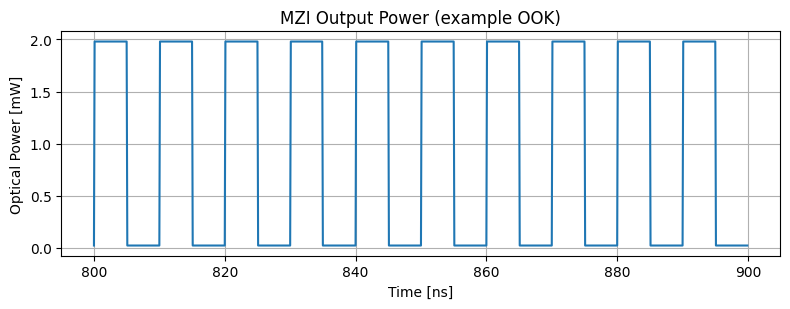

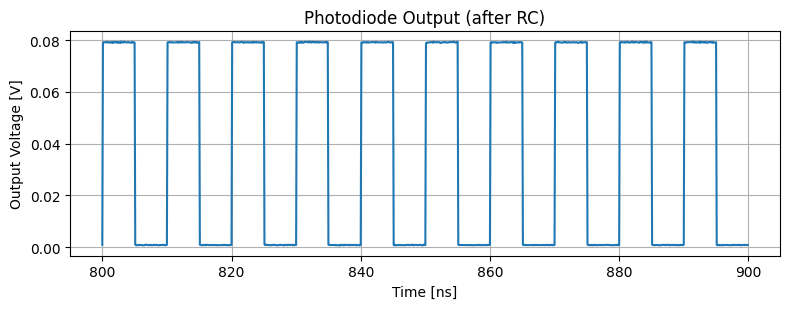

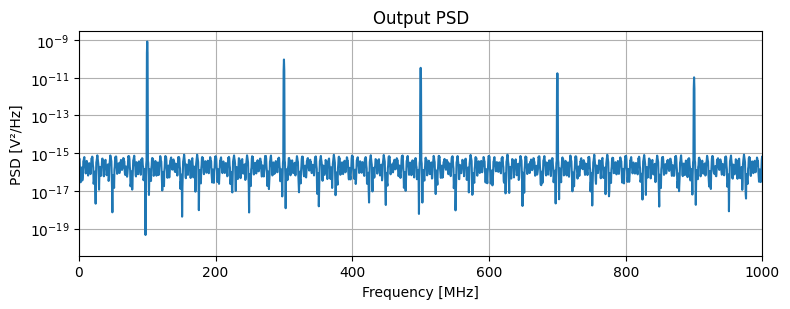

In [ ]:

# ============================================================
#   Example Simulation
# ============================================================

# Simulation parameters
fs   = 10e9      # 10 GHz sample rate
T    = 2e-6      # 2 microseconds total
N    = int(fs * T)
t    = np.arange(N) / fs

# Optical signal (OOK 100 MHz)
P_avg = 1e-3      # 1 mW average
mod_f = 100e6     # 100 MHz
bits  = (0.5 * (1 + np.sign(np.sin(2 * np.pi * mod_f * t))) > 0).astype(float)

ER_dB = 20.0
ER = 10 ** (-ER_dB / 10)
P_on  = 2 * P_avg / (1 + ER)
P_off = ER * P_on
P_t   = P_off + (P_on - P_off) * bits

# Detector setup
pd = PhotodiodeRC(
    responsivity=0.8,
    I_dark=2e-9,
    R_load=50.0,
    C_j=0.2e-12,
    C_par=0.1e-12,
    T=300.0,
    add_shot_noise=True,
    add_thermal_noise=True,
    seed=123
)

print(f"Estimated f_3dB ≈ {pd.f_3dB/1e9:.2f} GHz")
print(f"Thermal-floor NEP ≈ {pd.NEP():.2e} W/√Hz")

# ============================================================
#   Detect
# ============================================================
t, i_total, v_out = pd.detect(P_t, fs)

# Reference (no noise)
pd_no_noise = PhotodiodeRC(pd.R, pd.Id, pd.RL, pd.C, 0.0, pd.T,
                           add_shot_noise=False, add_thermal_noise=False)
_, _, v_ideal = pd_no_noise.detect(P_t, fs)

noise_only = v_out - v_ideal
snr_db = pd.estimate_SNR(v_ideal, noise_only)
print(f"Estimated output SNR ≈ {snr_db:.1f} dB")

# ============================================================
#   Plotting
# ============================================================

# Choose time window within 0–2 µs
i0, i1 = int(0.8e-6 * fs), int(0.9e-6 * fs)

plt.figure(figsize=(8, 3.2))
plt.plot(t[i0:i1] * 1e9, P_t[i0:i1] * 1e3)
plt.xlabel("Time [ns]")
plt.ylabel("Optical Power [mW]")
plt.title("MZI Output Power (example OOK)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3.2))
plt.plot(t[i0:i1] * 1e9, v_out[i0:i1])
plt.xlabel("Time [ns]")
plt.ylabel("Output Voltage [V]")
plt.title("Photodiode Output (after RC)")
plt.grid(True)
plt.tight_layout()
plt.show()

# PSD (spectrum)
win = np.hanning(len(v_out))
Vf = np.fft.rfft((v_out - np.mean(v_out)) * win)
ff = np.fft.rfftfreq(len(v_out), 1 / fs)
PSD = (np.abs(Vf) ** 2) / (np.sum(win ** 2) * fs)

plt.figure(figsize=(8, 3.2))
plt.semilogy(ff / 1e6, PSD + 1e-30)
plt.xlim(0, 1000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD [V²/Hz]")
plt.title("Output PSD")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


## ideal TIA

This code cell recovers the light_generation module in the event it was deleted or lost in the notebook session. It will add /mnt/data to the Python module search path, and then rewrite a clean version of the module including the LaserParams dataclass, the laser_power() function (which models optical output power above threshold), and the driver_current() function (which maps control voltage to laser drive current with clamping). By writing this code back to light_generation.py, all downstream photonic feedback simulations can run regardless of runtime resets when the imports, for example, from light_generation import LaserParams, laser_power, driver_current, are run.

In [ ]:
# Restore module path
import sys, os
sys.path.append('/mnt/data')

# Recreate the light_generation module (in case the file was cleared)
from dataclasses import dataclass
import numpy as np

module_code = r'''
from dataclasses import dataclass
import numpy as np

@dataclass
class LaserParams:
    I_th: float = 5e-3
    eta_slope: float = 0.5
    eta_couple: float = 0.9
    P_max: float | None = None

def laser_power(I, p: LaserParams):
    I_eff = np.maximum(0.0, I - p.I_th)
    P = p.eta_slope * I_eff * p.eta_couple
    if p.P_max is not None:
        P = np.minimum(P, p.P_max)
    return P

def driver_current(V_ctrl, I_bias, gm, I_min=0.0, I_max=50e-3):
    I = I_bias + gm * V_ctrl
    return np.clip(I, I_min, I_max)
'''
with open('/mnt/data/light_generation.py', 'w') as f:
    f.write(module_code)

print("✅ light_generation module restored.")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/light_generation.py'

This code represents a complete closed-loop system of optical power stabilization which includes the laser, the Mach–Zehnder modulator (MZM), waveguide loss, photodiode detection, transimpedance amplifier (TIA), and a proportional feedback controller. The controller modulates the output optical power at the photodiode output relative to a desired set voltage, on each time step, by adjusting the modulator (and indirectly the laser drive bias). The loop determines the laser's optical power, incorporates the MZM's cos² transfer function with insertion loss, and accounts for waveguide propagation loss, to get to the optical power, then results in photocurrent for TIA amplification to a voltage that represents the output optical power. The control law will then take the output voltage and compare it to its reference setpoint and update the control voltage. The plots below demonstrate how the control voltage behaves over time, along with how the optical output power stabilizes to an equivalently defined value, representing the closed-loop feedback control of the photonic integrated circuit system.

In [ ]:
# -------------------- CLOSED-LOOP FEEDBACK STAGE --------------------
import numpy as np
import matplotlib.pyplot as plt
from light_generation import LaserParams, laser_power, driver_current
from photodetector_tia import photodiode_current, tia_output

# Load previous stage outputs
t = np.load('/mnt/data/time_t.npy')
P_waveguide_t = np.load('/mnt/data/P_waveguide_t.npy')

# --- System Parameters ---
# Laser
p = LaserParams(I_th=5e-3, eta_slope=0.5, eta_couple=0.9)

# Modulator
V_pi = 2.0      # V for π phase shift
IL_dB = 3.0     # Insertion loss

# Waveguide
alpha = 3.0     # dB/cm
L = 0.05        # cm

# Photodiode
R_pd = 0.8      # A/W

# TIA
R_f = 10_000.0  # Ohm

# Controller
V_set = -2.0    # Desired photodiode voltage
K_p = 0.5       # Controller gain

# Initial conditions
I_bias = 6e-3   # Bias current
gm = 5e-3       # Transconductance (A/V)

# Pre-allocate arrays
V_ctrl = np.zeros_like(t)
I_laser = np.zeros_like(t)
P_laser = np.zeros_like(t)
P_mod = np.zeros_like(t)
P_wg = np.zeros_like(t)
I_pd = np.zeros_like(t)
V_tia = np.zeros_like(t)

# Helper functions
def mzm_transfer(P_in, V, V_pi, IL_dB):
    return P_in * np.cos(np.pi * V / V_pi)**2 * 10**(-IL_dB/10)

def waveguide_transmission(P_in, alpha_dB_per_cm, length_cm):
    return P_in * 10**(-(alpha_dB_per_cm * length_cm)/10)

# -------------------- Closed Loop Computation --------------------
for k in range(len(t)):
    # Compute electrical drive to laser
    I_laser[k] = driver_current(V_ctrl[k-1] if k>0 else 0, I_bias, gm)

    # Laser optical power
    P_laser[k] = laser_power(I_laser[k], p)

    # MZM modulation (feedback loop uses V_ctrl as modulator voltage too)
    P_mod[k] = mzm_transfer(P_laser[k], V_ctrl[k-1] if k>0 else 0, V_pi, IL_dB)

    # Waveguide transmission
    P_wg[k] = waveguide_transmission(P_mod[k], alpha, L)

    # Photodiode current
    I_pd[k] = photodiode_current(P_wg[k], R_pd)

    # TIA output
    V_tia[k] = tia_output(I_pd[k], R_f)

    # Controller update
    V_ctrl[k] = K_p * (V_set - V_tia[k])

# -------------------- Plots --------------------
plt.figure()
plt.plot(t*1e3, V_ctrl, linewidth=1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Control Voltage V_ctrl (V)")
plt.title("Control Voltage Over Time")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t*1e3, P_wg*1e3, linewidth=1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Output Optical Power (mW)")
plt.title("Closed-Loop Stabilized Optical Output")
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'light_generation'

end of note